In [ ]:
"""Case Study: Vessel Voyage Simulation

Objective:

Develop a simulation service that predicts a vessel’s movement based on various input parameters and generates a report on its journey.

Inputs:
	1.	Vessel IMO Number – Unique identifier for the vessel.
	2.	Vessel Hull Models – Structural and hydrodynamic properties of the vessel.
	3.	Simulation Start Date & Time – When the simulation begins.
	4.	Simulation Route – Sequence of waypoints (latitude, longitude).
	5.	Speed for Each Leg – Vessel speed for different segments of the journey.
	6.	Forecast Weather Data – Weather conditions (wind, waves, currents, temperature, etc.) during the voyage.
	7.	Monthly Average Weather Data – Historical weather trends for comparison.


  before starting simulation. break down the route into granular legs of 50 nautical miles.

  for each leg of voyage, calculate : (assume weather to be constant during that leg and assume weather to be of the start waypoint)
    1. time taken
    2. distance travelled
    3. speed
    4. cog (course over ground)
    5. weather data for start waypoint
  """

In [3]:
imo = 99901

# 1. Create mock weather data

# 2. Create hull models
# sog to stw
# stw to power
# power to foc

# 3. Voyage Inputs
start_datetime= "25-02-2025 02:00"
route = [[38.793333, -75.03], [38.431783, -74.711166], [35.266516, -74.2892],   [31.7061, -74.6371], [28.24305, -76.635], [27.511, -79.38475],  [26.4424, -79.29875]]
speed_knots = [10, 12, 8, 15, 9, 11]





In [ ]:
"""
create a resolution of 1 degree weather data point ie .

"-90_-180_0" : {"current_speed": 1,"current_direction":240},
"-90_-180_6" : {"current_speed": 1,"current_direction":240},
"-90_-180_12" : {"current_speed": 1,"current_direction":240},
"-90_-180_18" : {"current_speed": 1,"current_direction":240},
"-89_-180_24" : {"current_speed": 1,"current_direction":240},
...
..
..
..
"90_180_384" : {"current_speed": 1,"current_direction":240},
"""

In [120]:
import numpy as np
from xgboost import XGBRegressor
from math import radians
import math
from datetime import datetime
from sklearn.ensemble import R
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [116]:


# Calculate distsance between points such as lat and long
# Calculate time between two points
# Determine windspeed and direction for that time and source latitude and longitude from weather_data.
# set the output as detination latitude and destination longitude



# Create mock weather data
def generate_weather_data():
  time = np.arange(start=0, stop=385, step = 6)
  latitude = np.arange(start=-90,stop=91)
  longitude = np.arange(start = -180,stop = 181)
  speed = np.arange(start=0,stop= 7)
  direction = np.arange(start=0,stop= 241)
  weather_data = {}

  lat_long = [(str(lat)+"_"+str(long)+"_"+str(t)) for lat in latitude for long in longitude for t in time]
  # Mentioned the speeds and direction outside the loop to improve effeciency
  speeds = np.random.choice(speed, size = len(lat_long))
  directions = np.random.choice(direction, size = len(lat_long))
  start = 0
  for val in lat_long:
    curr_speed = speeds[start]
    curr_direction = directions[start]
    weather_data[val] =  {"current_speed":curr_speed, "current_direction":curr_direction}
    start+=1
  return weather_data


In [117]:
# Calculate distance betwen two points in ship route
def generate_distance():
  result_distance = []
  prev_lat, prev_long = route[0][0], route[0][1]
  for lat, long in route[1:]:
      curr_lat = lat
      curr_long = long
      lon1 = radians(prev_long)
      lon2 = radians(curr_long)
      lat1 = radians(curr_lat)
      lat2 = radians(prev_lat)

      # Haversine formula
      dlon = lon2 - lon1
      dlat = lat2 - lat1
      a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

      c = 2 * asin(sqrt(a))

      # Radius of earth in kilometers. Use 3956 for miles
      r = 6371


      result_distance.append(c*r)
      prev_long= curr_long
      prev_lat = curr_lat

  return result_distance


In [119]:
# Scale the time to fit time slots of the weather data in multiples of 6
def scale_num6(nums):
  res = []
  for num in nums:
    res.append(math.floor(num/6)*6)
  return res

In [122]:

# Calculate the scaled time
result_distance = generate_distance()
parsed_datetime = datetime.strptime(start_datetime, "%d-%m-%Y %H:%M")
start_hour = parsed_datetime.hour
time = start_hour
result_times=[]
for i in range(len(speed_knots)):
  time = time + (result_distance[i]/speed_knots[i])
  result_times.append(int(time))

scaled_times = scale_num6(result_times)


[6, 36, 84, 114, 144, 156]

In [123]:
# Calculate the data for prediction and input parameters


input_data =  pd.DataFrame()
input_data ['speed_knots']= speed_knots
input_data['time'] = scaled_times
src_lat = []
src_long = []
dst_lat = []
dst_long =[]
wind_speeds = []
wind_direction = []

for i in range(len(route)-1):
  src_lat.append(route[i][0])
  src_long.append(route[i][1])


for i in range(1,len(route)):
  dst_lat.append(route[i][0])
  dst_long.append(route[i][1])

input_data['source_lat']  = np.array(src_lat).astype(int)
input_data['source_long'] = np.array(src_long).astype(int)
input_data['destination_lat'] = np.array(dst_lat).astype(int)
input_data['destination_long'] = np.array(dst_long).astype(int)
weather_data = generate_weather_data()

coordinates = route[:len(route)-1]
time = input_data['time']
start = 0
wind_speed=[]
for coordinate in coordinates:
  lat,long = coordinate
  wind_speed.append(weather_data[str(int(lat))+"_"+str(int(long))+"_"+str(time[start])]['current_speed'])
  wind_direction.append(weather_data[str(int(lat))+"_"+str(int(long))+"_"+str(time[start])]['current_direction'])

input_data['wind_speed'] = np.array(wind_speed)
input_data['wind_direction'] = np.array(wind_direction)
X = input_data[['speed_knots','source_lat','source_long','wind_speed','wind_direction']]
y = input_data[['destination_lat','destination_long']]


input_data

,speed_knots,time,source_lat,source_long,destination_lat,destination_long,wind_speed,wind_direction
0,10,6,38,-75,38,-74,5,120
1,12,36,38,-74,35,-74,0,220
2,8,84,35,-74,31,-74,0,190
3,15,114,31,-74,28,-76,1,111
4,9,144,28,-76,27,-79,4,145
5,11,156,27,-79,26,-79,3,184


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()

In [125]:
model.fit(X_train, y_train)

LinearRegression()

In [126]:
# Generate prediction for the current input values for the parameters
y_prediction = model.predict(X)

In [127]:
y_prediction.tolist()

[[37.999999999999986, -74.0],
 [35.00000000000001, -74.0],
 [31.000000000000007, -74.0],
 [34.290838334516096, -76.49416562825348],
 [27.502911696744416, -77.42557457615236],
 [26.000000000000004, -79.0]]

In [129]:
# Add the predicted latitude and longitude values to the data frame
predicted_latitude = []
predicted_longitude = []
for lat_lon in y_prediction.tolist():
  lat = lat_lon[0]
  lon = lat_lon[1]
  predicted_latitude.append(lat)
  predicted_longitude.append(lon)

input_data['predicted_destination_latitude']= np.array(predicted_latitude)
input_data['predicted_destination_longitude']= np.array(predicted_longitude)

In [130]:
input_data

,speed_knots,time,source_lat,source_long,destination_lat,destination_long,wind_speed,wind_direction,predicted_destination_latitude,predicted_destination_longitude
0,10,6,38,-75,38,-74,5,120,38.000000,-74.000000
1,12,36,38,-74,35,-74,0,220,35.000000,-74.000000
2,8,84,35,-74,31,-74,0,190,31.000000,-74.000000
3,15,114,31,-74,28,-76,1,111,34.290838,-76.494166
4,9,144,28,-76,27,-79,4,145,27.502912,-77.425575
5,11,156,27,-79,26,-79,3,184,26.000000,-79.000000


Text(0, 0.5, 'Latitude')

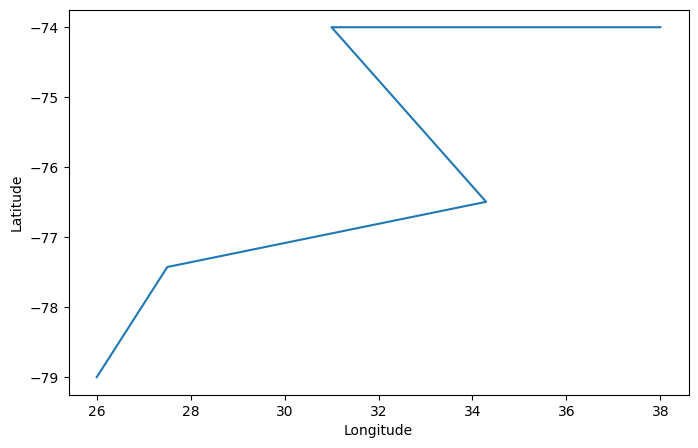

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(input_data['predicted_destination_latitude'],input_data['predicted_destination_longitude'], label='Predicted Path for vessel')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [ ]:
"""

Design a systems architecture design for the above service.

"""

